### Model Indexes Calculation

这个tutorial的目的是，根据model-fitting的结果计算AIC/BIC/pxp值。主要过程涉及：
1. 构建模型
2. 给定参数模拟出数据，然后用这些数据跑模型拟合
3. 计算拟合结果的模型指标（AIC/BIC/pxp）
4. 可视化指标结果

In [3]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from utils.draw import *
from utils.fit import *  
from utils.tools import *


#### 定义基础函数

In [4]:
##------------basic functions-------------##
def softmax(beta, values):
    '''softmax: p(x) = exp(x)/sum_(x') exp(x')'''
    values = np.array(values)
    # 在这个基础上加入inverse temperature 
    exp_vals = np.exp(beta * (values - np.max(values)))  # 避免溢出
    return exp_vals / np.sum(exp_vals)

def make_loss_fn(agent_class, nA):
    def loss_fn(params, data, *args):
        agent = agent_class(nA=nA, params=params, data=data)
        pi = agent.policy()
        actions = agent.actions
        eps = 1e-10
        return -np.sum(np.log(pi[np.arange(len(actions)), actions] + eps))
    return loss_fn

def clip_exp(x):
    x = np.clip(x, a_min=-1e15, a_max=50)
    return np.exp(x)

def sigmoid(x):
    p_param = 1/(1+clip_exp(-x))
    return p_param

def preprocess(actions, rewards):
    '''package data. in dataframe format'''
    df = pd.DataFrame({'actions': actions, 'rewards': rewards})
    return df


#### define models
* 这里用的是经典RW模型和固定了beta后的RW模型

In [5]:
##-----------------Model------------------##
class RW:
    '''The simplest RW model'''
    p_names  = ['alpha', 'beta']     # 参数名
    p_bnds  = [(0, 1), (-10, 10)]   # 取值范围
    p_pbnds = [(0, 0.5), (-5, 5)]   # 最后求解出的值最有可能落入的区间
    p_trans = [lambda x: sigmoid(x)] \
            + [lambda x: clip_exp(x)]
    color = np.array([34, 125, 81])/255.0
    name = 'RW'

    def __init__(self, nA, params, data):
        ## initialize the params and association values
        ## load data
        self.nA = nA                # 参数数量
        self.T = len(data)          # data长度，即试次数量

        # 在概率反转学习任务中需要的数据为被试选择的association和反馈（对/错）
        self.actions = data['actions'].values   
        self.rewards = data['rewards'].values

        # 初始化association values 和policy(选择任一association的概率)
        # 这里假定一共两种association。
        self.V = np.zeros((self.T, self.nA)) # V的形状[试次长度， association数量（2）]
        self.pi = None                       # set later
        self.load_params(params)             # 加载需拟合的参数

    def load_params(self, params):
        self.alpha = params[0]
        self.beta = params[1]

    def learn(self):
        '''
        define the learning process: prediction + update
        '''
        V = self.V
        for t in range(self.T):
            if t == 0:
                V[t] = np.zeros(self.nA)
            else:
                V[t] = V[t - 1].copy()
                # preload action at trial t
                a = self.actions[t]
                ##-------------prediction--------------## 
                # 预测误差(PE)源自前一次选择了特定association后:
                # 得到的反馈（reward)和对应更新的value
                # delta_(t-1) = r_(t-1) - V_(t-1, chosen association)
                delta = self.rewards[t - 1] - V[t - 1, a]

                ##---------------update----------------## 
                # 只更新当前选择的联结 a的价值
                # 基于PE 和 learning rate
                # V_t = V_(t-1) + learning rate * PE
                V[t, a] += self.alpha * delta
        return V

    def policy(self):
        '''get action probabilities of both association'''

        # 先加载已经更新好的value，形状(T, nA)
        V = self.learn()
        if self.pi is None:
            # 初始化policy
            self.pi = np.zeros((self.T, self.nA))
            for t in range(self.T):
                # 循环读取value后获得每一试次上任意一个action的概率
                self.pi[t] = softmax(self.beta, V[t])

        # 返回policy, 形状（T, nA。直接调取pi[action]即可获得对应的action probability        
        return self.pi 

    def simulate(self, T, seed=None):
        if seed is not None:
            np.random.seed(seed)
        '''
        验证模型过程：
        1. 先进行模拟: 给定参数后，产生模拟的被试数据
        2. 把这些数据用于模型拟合, model fitting后得到参数
        3. 真实参数和拟合参数进行相关分析。高则认为模型无误
        '''
        # 这里先初始化数据和association value
        V = np.zeros((T, self.nA))
        actions = np.zeros(T, dtype=int)
        rewards = np.zeros(T, dtype=int)

        for t in range(T):
            current_values = V[t - 1] if t > 0 else np.zeros(self.nA)
            # 同样使用softmax产生
            pi = softmax(self.beta, current_values)
            action = np.random.choice(self.nA, p=pi)
            reward = np.random.choice([0, 1])

            actions[t] = action
            rewards[t] = reward

            if t > 0:
                V[t] = V[t - 1].copy()
            V[t, action] += self.alpha * (reward - (V[t - 1, action] if t > 0 else 0))

        return actions, rewards, V
    
    
class FixedBetaRW(RW):
    '''RW model with fixed beta'''
    color = np.array([93, 172, 129])/255.0
    name = 'FixedBetaRW'
    def __init__(self, nA, params, data):
        # 提取参数
        self.alpha = params[0]  # alpha 从 params 中获取
        self.beta = 5.0  # beta 固定为 2
        super().__init__(nA, params=[self.alpha, self.beta], data=data)

    def policy(self):
        '''使用固定 beta 获取动作的概率分布'''
        V = self.learn()  # 使用继承自 RW 的 learn 方法
        pi = np.zeros((self.T, self.nA))
        for t in range(self.T):
            pi[t] = softmax(self.beta, V[t])  # 使用固定的 beta
        return pi


#### simulation --get data

In [6]:
# 生成被试数据的函数
def generate_subject_data(agent_class, nA, T, true_params):
    dummy_agent = agent_class(nA=nA, params=true_params, data=pd.DataFrame({'actions': np.zeros(T), 'rewards': np.zeros(T)}))
    actions, rewards, _ = dummy_agent.simulate(T)
    return preprocess(actions, rewards)


#### model-fitting

In [7]:
# 执行拟合的函数
def fit_subject_data(sub_id, loss_fn, data, bnds, pbnds, p_names):
    result = fit(
        loss_fn=loss_fn,
        data=data,
        bnds=bnds,
        pbnds=pbnds,
        p_name=p_names,
        p_priors=None,
        method='mle',
        alg='Nelder-Mead',
    )
    return sub_id, result

# 进行多被试拟合的函数
def fit_multiple_subjects(n_subjects, agent_class, nA, T, true_params, loss_fn, bnds, pbnds, p_names):
    fit_results = {}
    for i in range(n_subjects):
        # 为每个被试生成数据
        sub_id = f'subj{i}'
        
        data = generate_subject_data(agent_class, nA, T, true_params)
        
        # 执行拟合
        sub_id, result = fit_subject_data(sub_id, loss_fn, data, bnds, pbnds, p_names)
        
        # 保存结果
        fit_results[sub_id] = result
    return fit_results

In [8]:
# 定义参数
nA = 2
T = 100
true_params = [0.2, 2.0]  # 假设的真实参数
n_subjects = 5
method = 'mle'
models = ['RW', 'FixedBetaRW']
for model in models:
    # 定义损失函数
    loss_fn = make_loss_fn(eval(model), nA=2)

    # 进行多被试拟合
    fit_results = fit_multiple_subjects(n_subjects, RW, nA, T,
                                        true_params, loss_fn,
                                        RW.p_bnds, RW.p_pbnds, RW.p_names)

    # 存储结果
    pth = f'fits/fit_sub_info-{model}-{method}.pkl'
    dir_path = os.path.dirname(pth)
    os.makedirs(dir_path, exist_ok=True)
    with open(pth, 'wb') as handle: pickle.dump(fit_results, handle)

#### calculate AIC/BIC/pxp

In [9]:
models = ['RW', 'FixedBetaRW']
## 计算指标
# llh_table 是个包含了不同模型的nll/AIC/BIC的dataframe
# 需注意的是，这里的各个模型指标并非绝对值，而是相较于最优模型的相对值。
llh_table, pxp  = get_llh_score(models, fit_sub_info = fit_results, 
                          method = 'mle', use_bic=True)


##### visualize

c:\Users\yuyan\Desktop\model ftting\utils\draw.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  v=sns.violinplot(data=data,


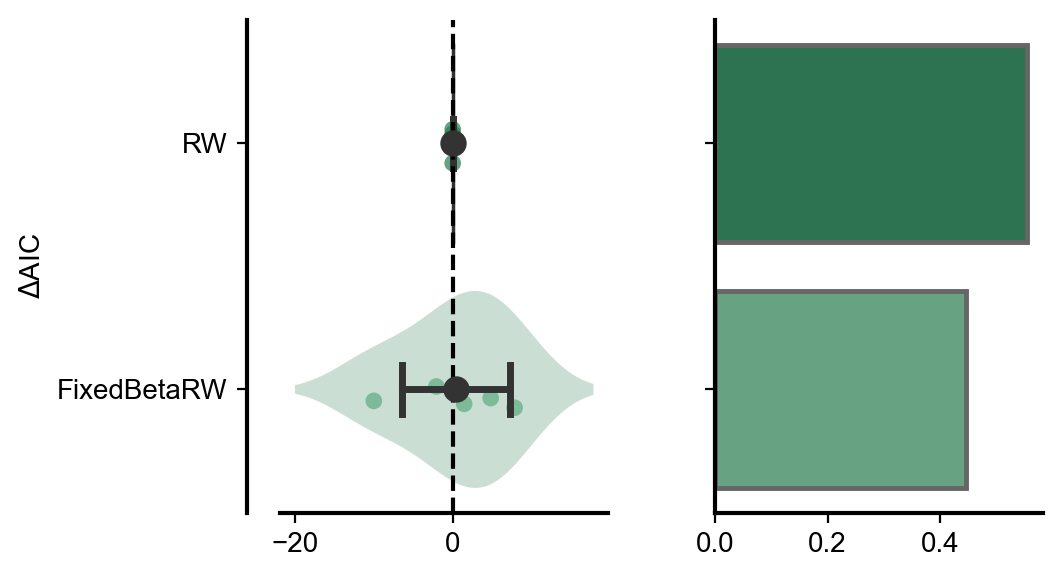

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)
font = {'family': 'Arial', 'weight': 'regular'}
# Apply the font settings
plt.rc('font', **font)
ax = axs[0]
index1 = 'AIC' # 这里的指标可以替换成BIC/NLL
index2 = 'pxp' 

palette = [eval(m).color for m in models]
violin(data=llh_table, x=f'{index1}', y='model', 
        order=models, orient='h', palette=palette,
        mean_marker_size=9.5, scatter_size=6, 
         err_capsize=.2,
        ax=ax)
ax.axvline(x=0, ymin=0, ymax=1, color='k', ls='--', lw=1.5)
lbl = [eval(m).name for m in models]

ax.set_yticks(list(range(len(models)))) 
ax.set_yticklabels(lbl)
ax.spines['left'].set_position(('axes',-0.1))
ax.set_ylabel(r'$\Delta$'+f'{index1}')
ax.set_xlabel('')
ax.set_box_aspect(1.5)
for pos in ['bottom','left']: ax.spines[pos].set_linewidth(1.5)
for pos in ['top','right']: ax.spines[pos].set_visible(False)

ax = axs[1]
palette = [eval(m).color for m in models]
sns.barplot(ax=ax, data=pxp, y='model', x=f'{index2}', 
            hue='model', edgecolor=[.4]*3, lw=1.75,
            palette=palette)

for pos in ['bottom','left']: ax.spines[pos].set_linewidth(1.5)
for pos in ['top','right']: ax.spines[pos].set_visible(False)
ax.set_ylabel(r'$\Delta$'+f'{index2}')
ax.set_xlabel('')
ax.set_box_aspect(1.5)
fig.tight_layout()
